In [1]:
import numpy as np
from matplotlib import pyplot as plt

from operator import itemgetter
from scipy.interpolate import splrep, BSpline

from rl.function_approx import *

### Modified from RL-book:

In [2]:
@dataclass(frozen=True)
class BSplineApprox(FunctionApprox[X]):
    feature_function: Callable[[X], float]
    degree: int
    knots: np.ndarray = field(default_factory=lambda: np.array([]))
    coeffs: np.ndarray = field(default_factory=lambda: np.array([]))

    def get_feature_values(self, x_values_seq: Iterable[X]) -> Sequence[float]:
        return [self.feature_function(x) for x in x_values_seq]

    def representational_gradient(self, x_value: X):
        feature_val: float = self.feature_function(x_value)
        eps: float = 1e-6
        one_hots: np.array = np.eye(len(self.coeffs))
        return replace(
            self,
            coeffs=np.array([(
                BSpline(
                    self.knots,
                    c + one_hots[i] * eps,
                    self.degree
                )(feature_val) -
                BSpline(
                    self.knots,
                    c - one_hots[i] * eps,
                    self.degree
                )(feature_val)
            ) / (2 * eps) for i, c in enumerate(self.coeffs)]))

    def evaluate(self, x_values_seq: Iterable[X]) -> np.ndarray:
        spline_func: Callable[[Sequence[float]], np.ndarray] = \
            BSpline(self.knots, self.coeffs, self.degree)
        return spline_func(self.get_feature_values(x_values_seq))

    def update(
        self,
        xy_vals_seq: Iterable[Tuple[X, float]]
    ):
        x_vals, y_vals = zip(*xy_vals_seq)
        feature_vals: Sequence[float] = self.get_feature_values(x_vals)
        sorted_pairs: Sequence[Tuple[float, float]] = \
            sorted(zip(feature_vals, y_vals), key=itemgetter(0))
        new_knots, new_coeffs, _ = splrep(
            [f for f, _ in sorted_pairs],
            [y for _, y in sorted_pairs],
            k=self.degree
        )
        return replace(
            self,
            knots=new_knots,
            coeffs=new_coeffs
        )

    def solve(
        self,
        xy_vals_seq: Iterable[Tuple[X, float]],
        error_tolerance: Optional[float] = None
    ):
        return self.update(xy_vals_seq)

    def within(self, other: FunctionApprox[X], tolerance: float) -> bool:
        if isinstance(other, BSplineApprox):
            return \
                np.all(np.abs(self.knots - other.knots) <= tolerance).item() \
                and \
                np.all(np.abs(self.coeffs - other.coeffs) <= tolerance).item()

        return False
    
    # Not super relevant
    def __add__(self, other):
        return self
    
    # Not super relevant
    def __mul__(self, scalar: float):
        return replace(
            self,
            coeffs=replace(
                self.coeffs,
                coeffs=self.coeffs * scalar
            )
        )
    
    # Not super relevant
    def objective_gradient(
        self,
        xy_vals_seq: Iterable[Tuple[X, float]],
        obj_deriv_out_fun: Callable[[Sequence[X], Sequence[float]], float]
    ):
        return None
    
    # Not super relevant
    def update_with_gradient(
        self,
        gradient
    ):
        return None

In [3]:
### Generating sequence

x_vals: np.ndarray = np.linspace(0,2*np.pi,100)
y_vals: np.ndarray = np.asarray([np.cos(x) for x in x_vals])

data: Iterable[Tuple[float,float]] = []
for i in range(50):
    data.append((x_vals[i], y_vals[i]))
    
    
Func_Approx_2 = BSplineApprox(
                lambda x: x,
                2)

Func_Approx_3 = BSplineApprox(
                lambda x: x,
                3)

Func_Approx_4 = BSplineApprox(
                lambda x: x,
                4)

Func_Approx_5 = BSplineApprox(
                lambda x: x,
                5)

Func_Approx_2 = Func_Approx_2.solve(data)
Func_Approx_3 = Func_Approx_3.solve(data)
Func_Approx_4 = Func_Approx_4.solve(data)
Func_Approx_5 = Func_Approx_5.solve(data)

approx_x_vals = np.linspace(0,2*np.pi,75)
approx_y_2 = Func_Approx_2.evaluate(approx_x_vals)
approx_y_3 = Func_Approx_3.evaluate(approx_x_vals)
approx_y_4 = Func_Approx_4.evaluate(approx_x_vals)
approx_y_5 = Func_Approx_5.evaluate(approx_x_vals)

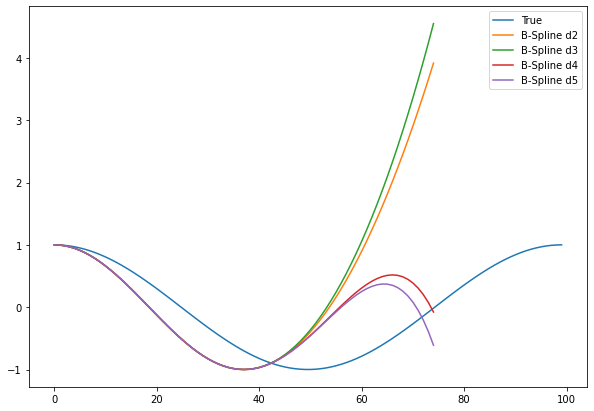

In [4]:
plt.figure(figsize=(10,7))
plt.plot(y_vals)
plt.plot(approx_y_2)
plt.plot(approx_y_3)
plt.plot(approx_y_4)
plt.plot(approx_y_5)
plt.legend(["True", "B-Spline d2", "B-Spline d3", "B-Spline d4", "B-Spline d5"])
plt.show()